# 환영합니다.

안녕하세요, 캐글을 접하기 어려우신 분들을 위해 한국어 버젼으로 노트북을 준비해봤습니다.

이 노트북은 [End to end simple and powerful DNN with LeakyReLU](https://www.kaggle.com/pythonash/end-to-end-simple-and-powerful-dnn-with-leakyrelu)라는 제 노트북의 한글 버젼 입니다.

이 노트북은 처음부터 끝까지(데이터셋 로딩 부터 제출 까지) 과정이 담겨 있지만, 차근차근 따라해보시면 그리 어렵진 않을 겁니다.

그리고 tensorflow나 keras를 이용해서 신경망을 사용하고 싶으신 분들에게는 더욱더 도움이 될 것으로 생각됩니다.

이 노트북을 작성했을 때 ver2 점수는 간단하게 0.146이 나왔으며 간단한 것 치고는 괜찮은 점수를 얻었다고 생각합니다.

여기서 끝이 아니라, 학습률과 같은 하이퍼 파라미터 튜닝을 통해서 더욱더 높은 점수를 얻어 보실 수 있습니다.

궁금하신 점이 있다면 답변을 달아주세요.

## **Knowledge can be improved by being shared.**

도움이 되셨다면 추천 한번씩 부탁드립니다!


## [신경망이나 데이터셋을 핸들링 하기 위한 다양한 노트북들]

- [Parallel DNN and CNN network for beginners](https://www.kaggle.com/pythonash/parallel-dnn-and-cnn-network-for-beginners) - **Pawpularity Contest (silver medal)**

- [Handling image and csv dataset at the same time](https://www.kaggle.com/pythonash/how-to-use-csv-and-img-at-the-same-time) - **Pawpularity Contest (bronze medal)**
 
- [Image data handling without memory exploded](https://www.kaggle.com/pythonash/how-to-handle-dataset-for-beginners) - **Pawpularity Contest (bronze medal)**

- [Data handling & Deep learning](https://www.kaggle.com/pythonash/how-to-handle-raw-dataset-and-analyze-with-dl) - **Titanic competition (best score!!, bronze medal)**

- [Deep learning model with SeLU activation function](https://www.kaggle.com/pythonash/selu-activation-function-in-dl) - **Titanic competition (bronze medal)**

- [Preparing a completed dataset with proper imputation method](https://www.kaggle.com/pythonash/making-completed-dataset) - **Titanic competition**
 
 
 
### [More contents or information]

## [Pythonash 깃허브](https://github.com/pythonash)

## [Pythonash 블로그](https://pythonash.github.io/ash)

**시작해볼까요?**

# 목차

<a id="toc"></a>
- [1. 라이브러리 불러오기](#1)
- [2. 데이터셋 불러오기](#2)
    - [2.1 데이터셋](#2.1) 
- [3. 모델 구축](#3)
    - [3.1 KFold 전략](#3.1)
- [4. 제출](#4)
- [5. 후기](#5)

<a id="1"></a>
# 라이브러리 불러오기

분석에 필요한 라이브러리들을 임포트 해오겠습니다.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import ubiquant
from sklearn.model_selection import KFold
from scipy.stats import pearsonr

<a id="2"></a>
# 데이터셋 불러오기

아시다시피 이 대회의 데이터셋은 18.55 기가바이트로 너무 큽니다.

그래서 우리는 다른 데이터셋을 사용할 건데요, 어떤 유저가 압축된 메모리(3.63 기가바이트)로 배포하고 있는 데이터 셋을 불러와 학습에 이용해줄 겁니다.

그 데이터셋에 대한 설명은 [ubiquant-parquet](https://www.kaggle.com/c/ubiquant-market-prediction/discussion/301724)에서 보실 수 있으며, 아래와 같이 검색 후 데이터를 추가할 수 있습니다.

공유해주셔서 감사합니다!! @Rob Mulla

**페이지 오른쪽 위에 있는 "+ Add data" 버튼을 클릭해주세요.**

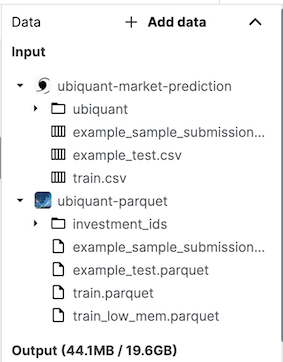

**그 다음, "ubiquant"를 검색하고 add를 클릭해주세요.**


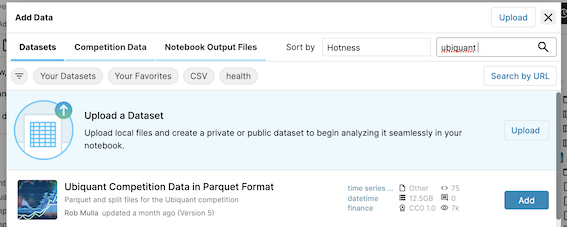

위 과정이 끝나면 parquet을 불러와 줍니다.

데이터셋을 한번 볼까요?

<a id="2.1"></a>
# 데이터셋

In [ ]:
df = pd.read_parquet('../input/ubiquant-parquet/train_low_mem.parquet')
df

## 결측값을 확인해 줍니다.

결측값은 없네요.

In [ ]:
df.isnull().sum().sum()

## 제출할 데이터의 형태를 살펴보겠습니다.

In [ ]:
pd.read_parquet('../input/ubiquant-parquet/example_sample_submission.parquet')

## 모든 변수들을 사용해줍니다.

사실, 제가 EDA와 여러 통계적 탐색을 해봤는데 의외로 데이터가 클린해서 그런지 모든 변수들을 사용하는 것이 더 성능이 좋게 나왔습니다.

물론, 저의 접근법이 완벽한것은 아니지만 그래도 하이퍼 파라미터 튜닝을 함으로써 robust한 결과를 얻으실 수 있습니다.

## 데이터 변수명들

In [ ]:
df.columns

## f_0 ~ f_299 변수들을 모두 사용하기 위해 따로 이름을 지정해줍니다.

In [ ]:
f_col = df.drop(['row_id','time_id','investment_id','target'],axis=1).columns
f_col

## investment_id 변수는 표준화 해줄겁니다.

"f_#" 변수가 살펴보니까 표준정규분포의 형태에 가깝기 때문에 학습에 이용될 investment_id 변수 또한 효율적인 학습을 위해 비슷한 형태로 변환해 줍니다.

그리고 테스트 데이터셋에도 같은 기준을 적용해주기 위해 따로 scaler를 만들어 두고 나중에 또 사용하겠습니다.

In [ ]:
scaler = StandardScaler()
scaler.fit(pd.DataFrame(df['investment_id']))

## 데이터셋 만드는 함수

테스트 데이터셋은 마지막 코드셀에서 대회에서 제공하는 API를 통해 제공됩니다.

그래서 이렇게 데이터셋을 만드는 함수를 만들어 두면 효율적으로 활용할 수 있습니다.

In [ ]:
def make_dataset(df):
    inv_df = df['investment_id']
    f_df = df[f_col]
    scaled_investment_id = scaler.transform(pd.DataFrame(inv_df))
    df['investment_id'] = scaled_investment_id
    data_x = pd.concat([df['investment_id'], f_df], axis=1)
    return data_x

## 데이터 타입을 바꿔줍니다.

노트북 메모리가 원래의 데이터셋을 그대로 활용하기에는 너무 작기 때문에 데이터 타입을 "float16"으로 바꿔줍니다.

그리고 이걸 다시 입력변수와 출력변수로 나누어 줍니다.

## 입력 변수

In [ ]:
df=df.astype('float16')
df_x = make_dataset(df)
df_x

## 출력 변수

In [ ]:
df_y = pd.DataFrame(df['target'])
df_y

## 원래 데이터 셋은 삭제해줍니다.

메모리가 터지는걸 막기 위해서, 용량을 많이 차지하고 있는 원래 데이터셋은 지워줍니다.

In [ ]:
del df

<a id="3"></a>
# 모델 구축

간단한 심층 신경망을 활용할 겁니다.

간단한 설명은 다음과 같습니다.

## 1. LeakyReLU 활성화 함수 사용하기.

- 파라미터를 지정해 줄 수 있습니다.

## 2. BatchNormalization 사용하기.

- 주로 활성화 함수 층 전에 사용됩니다.

## 3. Dropout 사용하기.

- Dropout 비율을 설정해 줄 수 있습니다.

## 4. kernel_initializer 파라미터를 'he_normal'로 지정해 줍니다.

- 'he_normal' 초기화 전략은 relu의 파생 함수들을 학습시키는데에 효율적 입니다.

## 5. 학습 스케쥴링 사용하기.

- 학습률을 점진적으로 바꿔가며 학습하는것이 성능을 높이는데에 도움이 될 수 있습니다.

## 6. ModelCheckpoint 사용하기.

- 가장 높은 성능이었을 때의 모델을 저장하기 위해 callbacks 파라미터에 ModelCheckpoint를 지정해 줍니다.


In [ ]:
def pythonash_model():
    inputs_ = tf.keras.Input(shape = [df_x.shape[1]])
    x = tf.keras.layers.Dense(64, kernel_initializer = 'he_normal')(inputs_)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)
    
    x = tf.keras.layers.Dense(128, kernel_initializer = 'he_normal')(leaky)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)
    
    x = tf.keras.layers.Dense(256, kernel_initializer = 'he_normal')(leaky)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)
    
    x = tf.keras.layers.Dense(512, kernel_initializer = 'he_normal')(leaky)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)
    
    x = tf.keras.layers.Dense(256, kernel_initializer = 'he_normal')(leaky)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)
    drop = tf.keras.layers.Dropout(0.4)(leaky)
    
    x = tf.keras.layers.Dense(128, kernel_initializer = 'he_normal')(drop)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)
    
    x = tf.keras.layers.Dense(8, kernel_initializer = 'he_normal')(leaky)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)
    drop = tf.keras.layers.Dropout(0.4)(leaky)
    
    outputs_ = tf.keras.layers.Dense(1)(drop)
    
    model = tf.keras.Model(inputs = inputs_, outputs = outputs_)
    
    rmse = tf.keras.metrics.RootMeanSquaredError()

    learning_sch = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.003,
    decay_steps = 9700,
    decay_rate = 0.98)
    adam = tf.keras.optimizers.Adam(learning_rate = learning_sch)
    
    model.compile(loss = 'mse', metrics = rmse, optimizer = adam)
    return model

pythonash_model().summary()

## 모델 그림

In [ ]:
tf.keras.utils.plot_model(pythonash_model(),show_shapes=True,expand_nested=True)

<a id="3.1"></a>
# KFold 전략

KFold 전략은 모델의 강건함을 평가하기 좋습니다.

더군다나, 데이터셋의 양이 많기 때문에 KFold를 사용하면 학습 과정과 과적합문제에 도움이 됩니다.

In [ ]:
kfold_generator = KFold(n_splits =5, shuffle=True, random_state = 2022)
kfold_generator

## 모델 적합

"for"문을 사용해서 KFold 전략을 사용할 수 있습니다.

In [ ]:
# 'pythonash_model.h5' 위치에 자신만의 모델 이름을 적어보세요.
callbacks = tf.keras.callbacks.ModelCheckpoint('pythonash_model.h5', save_best_only = True)
for train_index, val_index in kfold_generator.split(df_x, df_y):
    # 학습 데이터셋을 입력, 출력 변수로 나눠줍니다.
    train_x, train_y = df_x.iloc[train_index], df_y.iloc[train_index]
    # 검증용 데이터셋도 나눠줍니다.
    val_x, val_y = df_x.iloc[val_index], df_y.iloc[val_index]
    # 그리고 데이터셋들을 텐서로 바꿔줍니다.
    tf_train = tf.data.Dataset.from_tensor_slices((train_x, train_y)).shuffle(2022).batch(1024, drop_remainder=True).prefetch(1)
    tf_val = tf.data.Dataset.from_tensor_slices((val_x, val_y)).shuffle(2022).batch(1024, drop_remainder=True).prefetch(1)
    # 위에서 구축해준 모델을 불러와 줍니다.
    model = pythonash_model()
    # 모델 적합
    
    ## 저는 빠른 저장을 위해 에폭을 5까지만 지정했습니다.
    ## 에폭을 좀더 많은 수로 바꿔보세요.
    model.fit(tf_train, callbacks = callbacks, epochs = 5, #### 에폭을 좀더 많은 수로 바꿔 학습해 보시면 더 좋습니다.
             validation_data = (tf_val), shuffle=True)
    # 메모리가 터지는걸 막기 위해서 텐서 데이터셋과 모델을 매 반복마다 삭제해 줍니다.
    del tf_train
    del tf_val
    del model

<a id="4"></a>
# 제출

제출을 위해서 [competetion overview evaluation](https://www.kaggle.com/c/ubiquant-market-prediction/overview/evaluation)에서 제공하고 있는 코드를 따라하면 됩니다.

만약 어떻게 하는지 잘 모르시겠다면, 아래의 셀을 그대로 실행시켜 주시면 됩니다.



In [ ]:
best_model = tf.keras.models.load_model('pythonash_model.h5')
env = ubiquant.make_env()   
iter_test = env.iter_test()    
for (test_df, sample_prediction_df) in iter_test:
    test_df = make_dataset(test_df)
    sample_prediction_df['target'] = best_model.predict(test_df)  
    env.predict(sample_prediction_df)

<a id="5"></a>
# 후기

성능을 높이기 위해 이것저것 해봤던 기록들을 공유하고자 합니다.

## 1. 더 많은 뉴런을 쓰는 것이 꼭 좋은 것은 아니다.

> 더 많은 뉴런을 쓰는 것 보다는 더 많은 층을 쌓아 보시는게 도움이 될 수 있습니다.

## 2. LaekyReLU 파라미터나 학습률 파라미터를 바꿔보세요.

- LeakyReLU가 0.4 그리고 초기 학습률이 0.001 이었을 때 0.146 점수를 달성했습니다.

- 제 노트북에서는 LeakyReLU가 elu나 relu보다는 잘 작동합니다.

- LeakyReLU가 0.1 그리고 초기 학습률이 0.001 이었을 때 0.147 점수를 달성했습니다.

## 3. ModelCheckpoint와 EarlyStopping을 동시에 사용하면 메모리가 터질 수 있습니다.


## **끝났습니다!!**

도움이 되셨다면 추천 한번씩 해주세요!!

봐주셔서 감사합니다.